In [1]:
using Pkg
Pkg.activate(".")
Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.8"),
    PackageSpec(url="https://github.com/sadit/UMAP.jl", rev="bdcde9a54907f3e17b74317a0a94e9ff9c6ab701"),
    PackageSpec(name="Plots"),
    PackageSpec(name="Primes"),
    PackageSpec(name="StatsBase")
])

using SimilaritySearch, UMAP, Primes, Plots, StatsBase

  Activating project at `~/Research/SimilaritySearchDemos/synthetic`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Research/SimilaritySearchDemos/synthetic/Project.toml`
  No Changes to `~/Research/SimilaritySearchDemos/synthetic/Manifest.toml`


# Prime numbers
This demonstration is about prime numbers and its similarity based on its factors. This is a well-known demonstration of `UMAP.jl`. While this is not a _synthetic database_, it does not requires to download any dataset.



Now, we can define our dataset. The set of factors are found using the `Primes` package. Note that we use `VectorDatabase` to represent the dataset.

In [2]:
n = 100_000
F = Vector{Set{Int}}(undef, n)

for i in 2:n+1
    F[i-1] = factor(Set, i)
end

db = VectorDatabase(F)

VectorDatabase{Set{Int64}}(Set{Int64}[Set([2]), Set([3]), Set([2]), Set([5]), Set([2, 3]), Set([7]), Set([2]), Set([3]), Set([5, 2]), Set([11])  …  Set([29, 2, 431]), Set([33331, 3]), Set([2, 173, 17]), Set([5, 7, 2857]), Set([13, 2, 641, 3]), Set([277, 19]), Set([2, 49999]), Set([41, 3, 271]), Set([5, 2]), Set([11, 9091])])

We use Set objects to store prime factors to represent each integer. In the following cell we define three different distance functions working with this kind of representation. While other representations may perform faster, this is quite straighforward and demonstrates the use of user's defined distance functions.

In [3]:
function intersection_(U, V)
    if length(U) > length(V)
        U, V = V, U
    end
    
    d = 0
    for u in U
        if u in V
            d +=1
        end
    end

    d
end

struct JaccardSet <: SemiMetric end

function SimilaritySearch.evaluate(::JaccardSet, U, V)
    d = intersection_(U, V)
    1 - d / (length(U) + length(V) - d)
end

struct CosineDistanceSet <: SemiMetric end

function SimilaritySearch.evaluate(::CosineDistanceSet, U, V)
    d = intersection_(U, V)
    1 - d / (sqrt(length(U)) * sqrt(length(V)))
end

struct IntersectionDissSet <: SemiMetric end

function SimilaritySearch.evaluate(::IntersectionDissSet, U, V)
    d = intersection_(U, V)
    1 / (d + 1)
end

## Index construction
Note that the primes factors are pretty large for some large $n$ and this imply challengues for metric indexes (since it is related with the intrinsic dimension of the dataset). We used a kernel that starts 64 threads, it solves $100000$ in a few seconds but it can take pretty large time using single threads and larger $n$ values. The construction of the index is used by the visualization algorithm (UMAP) to construct an all-knn graph, which can be a quite costly procedure.

In [4]:
#dist = JaccardSet()
dist = CosineDistanceSet()
#dist = IntersectionDissSet()
G = SearchGraph(; db, dist)
push!(G.callbacks, OptimizeParameters(kind=ParetoRecall()))
index!(G; parallel_block=1000)
IJulia.clear_output()

0

## Visualizing with UMAP projection
We select to initialize the embedding randomly, this could yield to low quality embeddings, but it is much faster than other techniques like spectral layout. Note that we pass the Search graph `G`. We also use a second call to compute a 3D embedding for computing a kind of colour embedding, here we pass `U2` to avoid recomputing several of the involved structures.

In [5]:
U2 = UMAP_(G, 2; n_neighbors=15, init=:random)
U3 = UMAP_(U2, 3; init=:random)

(n, n_neighbors, n_components) = (100000, 15, 2)


*** computing allknn graph
*** computing graph
*** init embedding
*** fit ab / embedding
*** opt embedding


UMAP_{SparseArrays.SparseMatrixCSC{Float32, Int32}, Matrix{Float32}, SearchGraph{CosineDistanceSet, VectorDatabase{Set{Int64}}, BeamSearch}}(sparse(Int32[3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047  …  51529, 51669, 51709, 51789, 51889, 51969, 10, 120, 1330, 14640], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  99999, 99999, 99999, 99999, 99999, 99999, 100000, 100000, 100000, 100000], Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 100000, 100000), Float32[-5.074963 5.618516 … 1.0991352 6.4018574; 3.3511977 -8.9311495 … -4.451383 3.9541397; 7.383705 -1.7515082 … -11.712597 -2.657524], SearchGraph{CosineDistanceSet, VectorDatabase{Set{Int64}}, BeamSearch}
  dist: CosineDistanceSet CosineDistanceSet()
  db: VectorDatabase{Set{Int64}}
  links: Array{Vector{Int32}}((100000,))
  locks: Array{Base.Threads.SpinLock}((100000,))
  hints: Array{Int32}((108,)) Int32[525, 578, 632, 752, 1006, 1083, 1100, 1118, 1131, 1136  …  12340, 12401, 12426, 

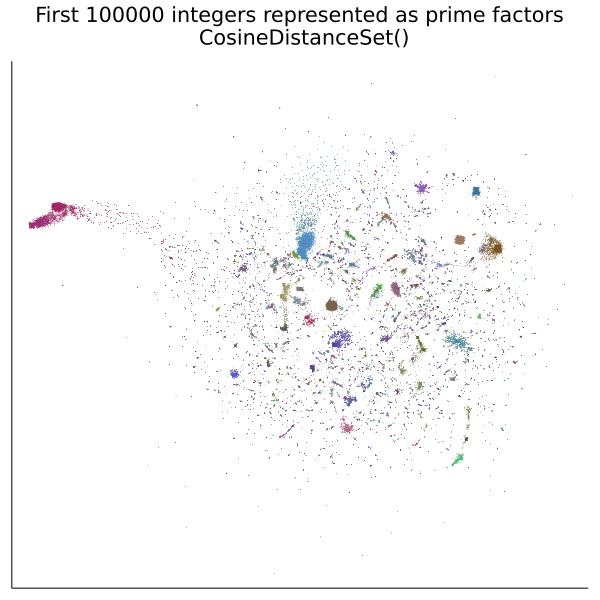

In [6]:
X = @view U2.embedding[1, :]
Y = @view U2.embedding[2, :]

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

C = copy(U3.embedding)
normcolors(@view C[1, :])
normcolors(@view C[2, :])
normcolors(@view C[3, :])

C = [RGB(c...) for c in eachcol(C)]

scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=1, msw=0, label="", yticks=nothing, xticks=nothing, title="First $n integers represented as prime factors\n $dist")
#savefig("umap-primes-1M.png")